In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('wordnet')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer

from numpy import mean
from numpy import std

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/SEM1/ML PROJECT/train.csv")

In [ ]:
df=train_data
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

In [ ]:
df['title'][1]

In [ ]:
df['text'][1]

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
label_count = df["label"].value_counts()
label_count

1    10413
0    10387
Name: label, dtype: int64

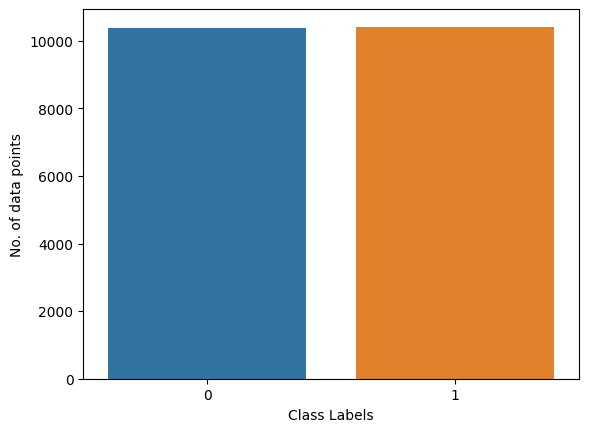

In [ ]:
sns.barplot(x=label_count.index, y=label_count.values); # since both label counts are almost same
                                                        # there is no class imbalance.
plt.xlabel("Class Labels")
plt.ylabel("No. of data points")
plt.show()

Dealing with the missing values in the dataframe

In [ ]:
# counting the number of missing values in the dataset,
# it counts the number of missing values in each column
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
df[df.title.isnull() & df.author.isnull()] #no rows contain null values simultaniously in author
                                           #and title column.

Empty DataFrame
Columns: [id, title, author, text, label]
Index: []

In [ ]:
# replacing the null values with empty string
df = df.fillna('')
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

**LABEL ENCODING**

In [ ]:
len(df['author'].unique())

4202

In [ ]:

lst=[]
for author in df.author.unique().tolist():
    new_df=df[df.author==author]
    if len(new_df[new_df.label==0])!=0 and len(new_df[new_df.label==1])!=0:
       lst.append(author)

In [ ]:
lst

['', 'Pam Key', 'Pamela Geller', 'Ann Coulter', 'AFP', 'Reuters']

In [ ]:
len(lst)

6

In [ ]:
#out of 4202 unique authors only  6 have turn out both fake and true news .Hence since most of authors turn out either fake or real news .

# **STEMMING + Stopwords Removal**

In [ ]:
from nltk.stem.porter import PorterStemmer
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]',' ',str(content))                                                                #remove non alphbetical letter
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()                                                                              # it convert list of word with space
  stemmed_content = [PorterStemmer().stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content

In [ ]:
df['stemm_content']= df['author'] +' '+ df['title']
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1   
1  Ever get the feeling your life circles the rou...      0   
2  Why the Truth Might Get You Fired October 29, ...      1   
3  Videos 15 Civilians Killed In Single US Airstr...      1   
4  Print \nAn Iranian woman has been sentenced to...      1   

                                       stemm_content  
0  Darrell Lucus House Dem Aide: We Didn’t Even S...  
1  Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...  
2  Consortiumnews.com Why the Truth Might Get You...  
3  Jessica Purkiss 15 Civilians Killed In Single ...  
4  Howard Portnoy Iranian woman jailed for fictio...

In [ ]:
df['stemm_content'] =df['stemm_content'].apply(stemming)

In [ ]:
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1   
1  Ever get the feeling your life circles the rou...      0   
2  Why the Truth Might Get You Fired October 29, ...      1   
3  Videos 15 Civilians Killed In Single US Airstr...      1   
4  Print \nAn Iranian woman has been sentenced to...      1   

                                       stemm_content  
0  darrel lucu hous dem aid even see comey letter...  
1  daniel j flynn flynn hillari clinton big woman...  
2             consortiumnew com truth might get fire  
3  jessica purkiss civilian kill singl us airstri...  
4  howard portnoy iranian woman jail fiction unpu...

# **LEMMATIZATION + Stopwords Removal**

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')  #downloading the stopwords from natural Language Toolkit

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
def cleaning_lemmetize(content):
    document = re.sub('[^a-zA-Z]',' ',str(content))
    document = document.lower()
    document = document.split()
    document = [WordNetLemmatizer().lemmatize(word) for word in document if not word in stopwords.words('english')]
    document = ' '.join(document)
    return document

In [ ]:
df['lemm_content']=(df['title'] +' '+ df['text']).apply(cleaning_lemmetize)
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1   
1  Ever get the feeling your life circles the rou...      0   
2  Why the Truth Might Get You Fired October 29, ...      1   
3  Videos 15 Civilians Killed In Single US Airstr...      1   
4  Print \nAn Iranian woman has been sentenced to...      1   

                                        lemm_content  
0  house dem aide even see comey letter jason cha...  
1  flynn hillary clinton big woman campus breitba...  
2  truth might get fired truth might get fired oc...  
3  civilian killed single u airstrike identified ...  
4  iranian woman jailed fictional unpublished sto...

In [ ]:
Y = df['label'].values

# **BAG-OF-WORDS**

In [ ]:
BOW_vectorizer = CountVectorizer()                                                    # make a list of all words in all sentence . and for every sentence make a
X_stemm_bow = BOW_vectorizer.fit_transform(df['lemm_content'].values)                # list of size all word and word is present the number of count of each word in a document.

In [ ]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X_stemm_bow, Y, test_size = 0.3)

In [ ]:
X_stemm_bow

<20800x18672 sparse matrix of type '<class 'numpy.int64'>'
	with 170221 stored elements in Compressed Sparse Row format>

**Logistic Regression**

In [ ]:
log_reg1=LogisticRegression()                                                           #use sigmoid function, in which give any negetive value, fun will give
log_reg1.fit(X_train1,Y_train1)                                                         #value b/w 0 to 0.5 and any positive value ,fun will give 0.5 to 1 .

Y_lr_train_pred1 =log_reg1.predict(X_train1)                                            # Z=theta0+ theta1*x + ....     h_theta= sig(z)
Y_lr_test_pred1 =log_reg1.predict(X_test1)                                              # loss mim--- means try to do h_theta= 1 if its lable is 1 ,and if lable is 0
                                                                                        # then try to do h_theta =0  .With theta variable and gradient desent.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train1,Y_lr_train_pred1))

print(f"The accuracy score for train data is {accuracy_score(Y_train1,Y_lr_train_pred1)}")

print('The classification report is:')
print(classification_report(Y_train1,Y_lr_train_pred1))
dict_train={}
dict_train['LogisticRegression']=accuracy_score(Y_train1,Y_lr_train_pred1)

the confusion matrix for train data is:
[[7251    0]
 [   0 7309]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7251
           1       1.00      1.00      1.00      7309

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test1,Y_lr_test_pred1))

print(f"the accuracy score for train data is {accuracy_score(Y_test1,Y_lr_test_pred1)}")

print('The classification report is:')
print(classification_report(Y_test1,Y_lr_test_pred1))
dict_test={}
dict_test['LogisticRegression']=accuracy_score(Y_test1,Y_lr_test_pred1)

the confusion matrix for test data is:
[[2984  152]
 [ 111 2993]]
the accuracy score for train data is 0.9578525641025641
The classification report is:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3136
           1       0.95      0.96      0.96      3104

    accuracy                           0.96      6240
   macro avg       0.96      0.96      0.96      6240
weighted avg       0.96      0.96      0.96      6240



**Decision Tree**

In [ ]:
my_dt1 = DecisionTreeClassifier()                                         # we have feature vecture for each sentence or each data
my_dt1.fit(X_train1,Y_train1)                                             # chose on feature(word in case) by information gain(higher one) and see how many possiblities(in case persent or not in BOW-vector)
                                                                          # if persent or absent then what is effect on label fake or not, if clearly decide (persent=fake or absent=fake or ..)(pure leaf Entropy =0)
Y_dt_train_pred1 =my_dt1.predict(X_train1)                                #if not decided like present 5 data say fake and 4 data say not fake. then
Y_dt_test_pred1 =my_dt1.predict(X_test1)                                  #take dataset1 have only persent and dataset have only absent. dataset1 have all feature except 1st chosen feature.
                                                                          # based on dataset1 do same to find best feature (which has higher information gain)and ....
                                                                          # do same for dataset2.....

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train1,Y_dt_train_pred1))

print(f"The accuracy score for train data is {accuracy_score(Y_train1,Y_dt_train_pred1)}")
dict_train['DecisionTree']=accuracy_score(Y_train1,Y_dt_train_pred1)
print('The classification report is:')
print(classification_report(Y_train1,Y_dt_train_pred1))

the confusion matrix for train data is:
[[7251    0]
 [   0 7309]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7251
           1       1.00      1.00      1.00      7309

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test1,Y_dt_test_pred1))

print(f"the accuracy score for train data is {accuracy_score(Y_test1,Y_dt_test_pred1)}")
dict_test['DecisionTree']=accuracy_score(Y_test1,Y_dt_test_pred1)
print('The classification report is:')
print(classification_report(Y_test1,Y_dt_test_pred1))

the confusion matrix for test data is:
[[2922  214]
 [ 179 2925]]
the accuracy score for train data is 0.9370192307692308
The classification report is:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3136
           1       0.93      0.94      0.94      3104

    accuracy                           0.94      6240
   macro avg       0.94      0.94      0.94      6240
weighted avg       0.94      0.94      0.94      6240



**Random Forest Classifier**

In [ ]:
my_rf1 = RandomForestClassifier()                                                 #  DT trained on whole training data set that may cause overfiting(low bais and high variance)
my_rf1.fit(X_train1,Y_train1)                                                     # but in Random forest(both low(traid of)) DT, the defferent DT take random subset(bootstrap) of training data, that
                                                                                 # it may occur some similar data point and feature .
Y_rf_train_pred1 =my_rf1.predict(X_train1)                                        # in simple data set DT will work but Random forest also work in complex reletion
Y_rf_test_pred1 =my_rf1.predict(X_test1)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train1,Y_rf_train_pred1))

print(f"The accuracy score for train data is {accuracy_score(Y_train1,Y_rf_train_pred1)}")
dict_train['RandomForest']=accuracy_score(Y_train1,Y_rf_train_pred1)
print('The classification report is:')
print(classification_report(Y_train1,Y_rf_train_pred1))

the confusion matrix for train data is:
[[7251    0]
 [   0 7309]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7251
           1       1.00      1.00      1.00      7309

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test1,Y_rf_test_pred1))

print(f"the accuracy score for train data is {accuracy_score(Y_test1,Y_rf_test_pred1)}")
dict_test['RandomForest']=accuracy_score(Y_test1,Y_rf_test_pred1)
print('The classification report is:')
print(classification_report(Y_test1,Y_rf_test_pred1))

the confusion matrix for test data is:
[[2971  165]
 [ 314 2790]]
the accuracy score for train data is 0.9232371794871795
The classification report is:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      3136
           1       0.94      0.90      0.92      3104

    accuracy                           0.92      6240
   macro avg       0.92      0.92      0.92      6240
weighted avg       0.92      0.92      0.92      6240



**Multinomial Naive Bayes Classifier**

In [ ]:
my_nbc1 = MultinomialNB()                                                 #Bayes' theorem, which calculates the conditional probability of a class given an input feature
my_nbc1= my_nbc1.fit(X_train1,Y_train1)                                   #Assumption:features are conditionally independent
                                                                          #Each class is associated with a multinomial distribution of probabilities,
Y_nbc_train_pred1 = my_nbc1.predict(X_train1)                             #During training, the classifier estimates the parameters of the multinomial distributions for each class based on the training data
Y_nbc_test_pred1 = my_nbc1.predict(X_test1)                               #Laplace Smoothing: To handle cases where a feature has zero probability in a class,
                                                                          #This prevents zero probabilities and ensures that each feature contributes to the classification decision.

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train1,Y_nbc_train_pred1))

print(f"The accuracy score for train data is {accuracy_score(Y_train1,Y_nbc_train_pred1)}")
dict_train['MultinomialNB']=accuracy_score(Y_train1,Y_nbc_train_pred1)
print('The classification report is:')
print(classification_report(Y_train1,Y_nbc_train_pred1))

the confusion matrix for train data is:
[[7024  227]
 [ 689 6620]]
The accuracy score for train data is 0.9370879120879121
The classification report is:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7251
           1       0.97      0.91      0.94      7309

    accuracy                           0.94     14560
   macro avg       0.94      0.94      0.94     14560
weighted avg       0.94      0.94      0.94     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test1,Y_nbc_test_pred1))

print(f"the accuracy score for test data is {accuracy_score(Y_test1,Y_nbc_test_pred1)}")
dict_test['MultinomialNB']=accuracy_score(Y_test1,Y_nbc_test_pred1)
print('The classification report is:')
print(classification_report(Y_test1,Y_nbc_test_pred1))

the confusion matrix for test data is:
[[2977  159]
 [ 431 2673]]
the accuracy score for test data is 0.905448717948718
The classification report is:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3136
           1       0.94      0.86      0.90      3104

    accuracy                           0.91      6240
   macro avg       0.91      0.91      0.91      6240
weighted avg       0.91      0.91      0.91      6240



**K-Nearest Neighbour**

In [ ]:
param_grid_knn1 = {"n_neighbors": [3,5,7,9,11,13,15]}                                      # For a new, unlabeled data point, K-NN identifies the "k" training data points
                                                                                            #that are closest to the new point based on the chosen distance metric.
knn1 = KNeighborsClassifier()                                                                    #It then looks at the class labels of these "k" neighbors and determines the majority class.
                                                                                                 #The new data point is assigned the class label that is most common among its "k" nearest neighbors.
grid_knn1= GridSearchCV(estimator=knn1,param_grid=param_grid_knn1,scoring="accuracy",verbose=1)

grid_knn1 = grid_knn1.fit(X_train1,Y_train1)

print(grid_knn1.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'n_neighbors': 3}


In [ ]:
my_knn1 = KNeighborsClassifier(n_neighbors=3)
my_knn1 = my_knn1.fit(X_train1,Y_train1)

Y_knn_train_pred1 = my_knn1.predict(X_train1)
Y_knn_test_pred1 = my_knn1.predict(X_test1)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train1,Y_knn_train_pred1))

print(f"the accuracy score for train data is {accuracy_score(Y_train1,Y_knn_train_pred1)}")
dict_train['KNN']=accuracy_score(Y_train1,Y_knn_train_pred1)
print('The classification report is:')
print(classification_report(Y_train1,Y_knn_train_pred1))

the confusion matrix for train data is:
[[4818 2433]
 [ 137 7172]]
the accuracy score for train data is 0.823489010989011
The classification report is:
              precision    recall  f1-score   support

           0       0.97      0.66      0.79      7251
           1       0.75      0.98      0.85      7309

    accuracy                           0.82     14560
   macro avg       0.86      0.82      0.82     14560
weighted avg       0.86      0.82      0.82     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test1,Y_knn_test_pred1))

print(f"the accuracy score for test data is: {accuracy_score(Y_test1,Y_knn_test_pred1)}")
dict_test['KNN']=accuracy_score(Y_test1,Y_knn_test_pred1)
print('The classification report is:')
print(classification_report(Y_test1,Y_knn_test_pred1))

the confusion matrix for test data is:
[[1726 1410]
 [ 109 2995]]
the accuracy score for test data is: 0.7565705128205128
The classification report is:
              precision    recall  f1-score   support

           0       0.94      0.55      0.69      3136
           1       0.68      0.96      0.80      3104

    accuracy                           0.76      6240
   macro avg       0.81      0.76      0.75      6240
weighted avg       0.81      0.76      0.75      6240



**SVC**

In [ ]:
param_grid_svm1 = {"kernel": ['linear','rbf','poly','sigmoid']}

svm1 = SVC()

grid_svm1= GridSearchCV(estimator=svm1,param_grid=param_grid_svm1,scoring="accuracy",verbose=1)

grid_svm1 = grid_svm1.fit(X_train1,Y_train1)

print(grid_svm1.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'kernel': 'linear'}


In [ ]:
my_svm1 = SVC( kernel='linear')                                            #SVM aims to find the hyperplane that maximizes the margin between the two classes.
my_svm1 = my_svm1.fit(X_train1,Y_train1)                                   #The data points that are closest to the hyperplane and are responsible for defining the margin are called support vectors.
                                                                           #Soft Margin:a trade-off between maximizing the margin and minimizing the misclassification.
Y_svm_train_pred1 = my_svm1.predict(X_train1)                              #Kernel Trick :A kernel function transforms the original feature space into a higher-dimensional space, where the data might become linearly separable.
                                                                           #kernel functions include Polynomial, Radial Basis Function (RBF), and Sigmoid kernels.
Y_svm_test_pred1 = my_svm1.predict(X_test1)                                #To classify a new data point, SVM calculates its position relative to the learned hyperplane.

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train1,Y_svm_train_pred1))

print(f"the accuracy score for train data is {accuracy_score(Y_train1,Y_svm_train_pred1)}")
dict_train['SVC']=accuracy_score(Y_train1,Y_svm_train_pred1)
print('The classification report is:')
print(classification_report(Y_test1,Y_svm_test_pred1))

the confusion matrix for train data is:
[[7251    0]
 [   0 7309]]
the accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3136
           1       0.95      0.95      0.95      3104

    accuracy                           0.95      6240
   macro avg       0.95      0.95      0.95      6240
weighted avg       0.95      0.95      0.95      6240



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test1,Y_svm_test_pred1))

print(f"the accuracy score for test data is: {accuracy_score(Y_test1,Y_svm_test_pred1)}")
dict_test['SVC']=accuracy_score(Y_test1,Y_svm_test_pred1)
print('The classification report is:')
print(classification_report(Y_test1,Y_svm_test_pred1))

the confusion matrix for test data is:
[[2975  161]
 [ 151 2953]]
the accuracy score for test data is: 0.95
The classification report is:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3136
           1       0.95      0.95      0.95      3104

    accuracy                           0.95      6240
   macro avg       0.95      0.95      0.95      6240
weighted avg       0.95      0.95      0.95      6240



**Plotting accuracy of models**

test accuracy {'LogisticRegression': 0.9578525641025641, 'DecisionTree': 0.9370192307692308, 'RandomForest': 0.9232371794871795, 'MultinomialNB': 0.905448717948718, 'KNN': 0.7565705128205128, 'SVC': 0.95}
train accuracy {'LogisticRegression': 1.0, 'DecisionTree': 1.0, 'RandomForest': 1.0, 'MultinomialNB': 0.9370879120879121, 'KNN': 0.823489010989011, 'SVC': 1.0}


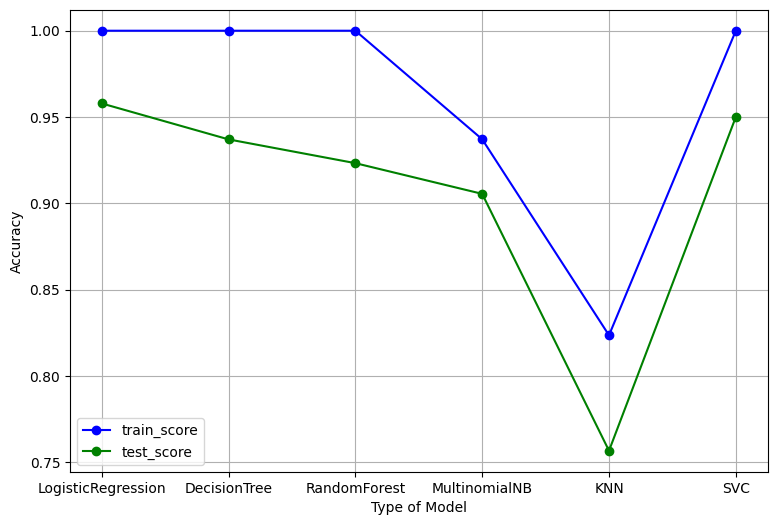

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.plot(dict_train.keys(),dict_train.values(),marker='o',c='b',label='train_score')
plt.plot(dict_test.keys(),dict_test.values(),marker='o',c='g',label='test_score')
plt.grid()
plt.legend()
plt.xlabel('Type of Model')
plt.ylabel('Accuracy')
print('test accuracy',dict_test)
print('train accuracy',dict_train)

**CROSS VALIDATION TO GET THE BEST ALGORITHM**

In [ ]:
from sklearn import model_selection
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('MultinomialNB', MultinomialNB( )))

models.append(('KNN', KNeighborsClassifier(n_neighbors=3)))
models.append(('SVC', SVC(kernel='linear')))
seed = 7
# evaluate each model in turn
dict_models={}
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, )
	cv_results = model_selection.cross_val_score(model, X_stemm_bow, Y, cv=kfold, scoring=scoring)
	dict_models[name]=cv_results.mean()
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression: 0.962260 (0.002989)
DecisionTreeClassifier: 0.941538 (0.006894)
RandomForestClassifier: 0.928077 (0.003283)
MultinomialNB: 0.906250 (0.006396)
KNN: 0.763846 (0.010733)
SVC: 0.954712 (0.002551)


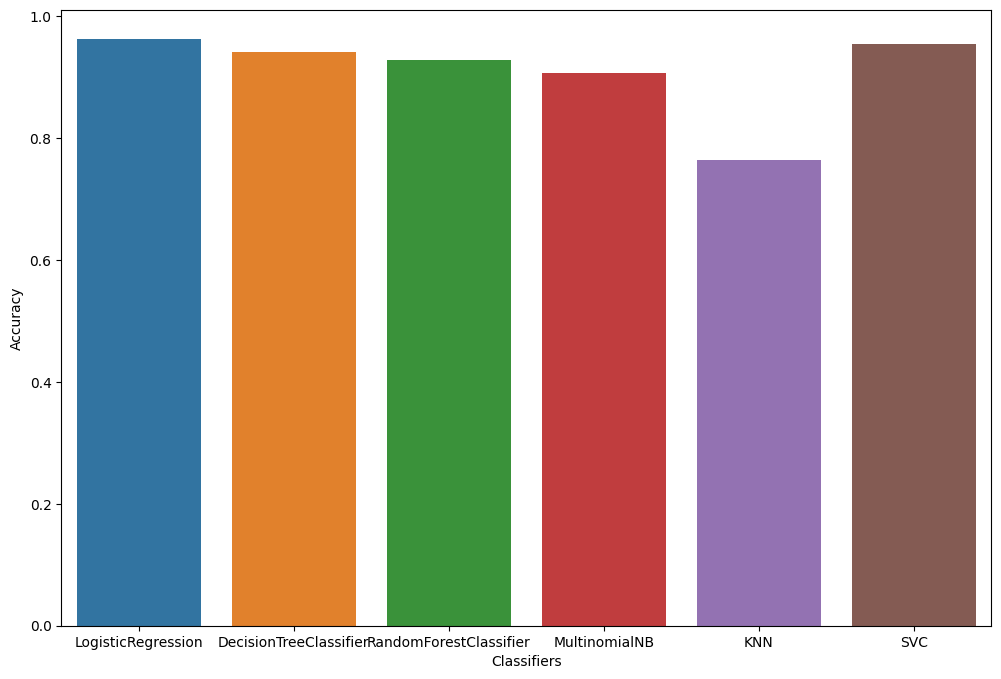

In [ ]:


import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x=list(dict_models.keys()),y=list(dict_models.values()),ax=ax)

plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.show()

**Hypothesis Testing between Decision Tree Classifier and SVC**

In [ ]:
# use 5x2 statistical hypothesis testing procedure to compare two machine learning algorithms


from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
# evaluate model 1
model1 = DecisionTreeClassifier()


# evaluate model 2
model2 = SVC(kernel='linear')

# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=X_stemm_bow, y=Y, scoring='accuracy', random_seed=1)
# summarize
print('P-value:',p, 't-Statistic:',t)
# interpret the result
if p <= 0.05:
	print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two models are significantly different.')
else:
	print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.')

P-value: 0.6374992087084718 t-Statistic: -0.5012197265030894
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.


# **BAG-OF WORDS + CHI SQUARED TEST**

In [ ]:
X_names1 = BOW_vectorizer.get_feature_names()

C:\Users\adity\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
chi2, p = chi2(X_stemm_bow, Y)

In [ ]:
data1={'features':X_names1,'score':p}
df_features1=pd.DataFrame(data1)

In [ ]:
alpha=.05

In [ ]:
df_features_new1=df_features1[df_features1.score<alpha]                                   # chi2 for feacher selection which is highly dependent on response or in this case word selection
df_features_new1                                                                          # chi squred test, higher the chi score value higher the dependent
                                                                                          #If the calculated chi-squared value is greater than the critical value, you reject the null hypothesis
                                                                                          #and conclude that there is a significant relationship between the feature and the target variable.
                                                                                          #This suggests that the feature is relevant for classification.
                                                                                          #so give min createria that min value of dependence is required.


features         score
5        aaron  7.437698e-08
13        abbi  1.587905e-03
24         abe  2.247902e-03
26      abedin  5.599195e-07
28     abelson  6.201666e-05
...        ...           ...
17089  zionist  6.469340e-05
17095    zombi  4.577073e-02
17102   zraick  3.117645e-13
17104       zu  9.247221e-04
17112    zuess  2.805669e-06

[3036 rows x 2 columns]

In [ ]:
X_names_new1=list(df_features_new1.features.values)
X_names_new1

['aaron',
 'abbi',
 'abe',
 'abedin',
 'abelson',
 'aboard',
 'abort',
 'abram',
 'abroad',
 'abus',
 'access',
 'accur',
 'acknowledg',
 'acosta',
 'acquit',
 'activist',
 'activistpost',
 'actual',
 'acuesta',
 'adam',
 'add',
 'adebayo',
 'adel',
 'adelmann',
 'adhd',
 'adl',
 'adler',
 'admin',
 'administr',
 'admit',
 'adpr',
 'advert',
 'advic',
 'advis',
 'afghan',
 'agorist',
 'agre',
 'agreement',
 'ahca',
 'ahm',
 'ahmad',
 'ahtribun',
 'ail',
 'aim',
 'airbag',
 'airlin',
 'airstrik',
 'aker',
 'akihito',
 'al',
 'aladdinsmiraclelamp',
 'alan',
 'alaska',
 'albrecht',
 'alcindor',
 'alderman',
 'aleppo',
 'alert',
 'alessandra',
 'alex',
 'alexa',
 'alexandra',
 'alfano',
 'ali',
 'alisha',
 'alison',
 'alissa',
 'all',
 'allan',
 'allegedli',
 'alli',
 'allison',
 'allum',
 'almost',
 'alphabet',
 'alreadi',
 'alt',
 'alter',
 'altern',
 'altruist',
 'alvarez',
 'amando',
 'amaz',
 'amazon',
 'ambella',
 'ambit',
 'america',
 'american',
 'amid',
 'ammo',
 'ammon',
 'ampt',

In [ ]:
vectorizer1 = CountVectorizer(vocabulary=X_names_new1)
vectorizer1.fit(df['stemm_content'].values)
X_stemm_bow_chi = vectorizer1.transform(df['stemm_content'].values)  #USEFUL

In [ ]:
X_stemm_bow_chi

<20800x3036 sparse matrix of type '<class 'numpy.int64'>'
	with 129947 stored elements in Compressed Sparse Row format>

In [ ]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_stemm_bow_chi, Y, test_size = 0.3)

**Logistic Regression**

In [ ]:
log_reg2=LogisticRegression()
log_reg2.fit(X_train2,Y_train2)

Y_lr_train_pred2 =log_reg2.predict(X_train2)
Y_lr_test_pred2 =log_reg2.predict(X_test2)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train2,Y_lr_train_pred2))

print(f"The accuracy score for train data is {accuracy_score(Y_train2,Y_lr_train_pred2)}")

print('The classification report is:')
print(classification_report(Y_train2,Y_lr_train_pred2))
dict_train={}
dict_train['LogisticRegression']=accuracy_score(Y_train2,Y_lr_train_pred2)

the confusion matrix for train data is:
[[7270   38]
 [  25 7227]]
The accuracy score for train data is 0.9956730769230769
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7308
           1       0.99      1.00      1.00      7252

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test2,Y_lr_test_pred2))

print(f"the accuracy score for train data is {accuracy_score(Y_test2,Y_lr_test_pred2)}")

print('The classification report is:')
print(classification_report(Y_test2,Y_lr_test_pred2))
dict_test={}
dict_test['LogisticRegression']=accuracy_score(Y_test2,Y_lr_test_pred2)

the confusion matrix for test data is:
[[3046   33]
 [  15 3146]]
the accuracy score for train data is 0.9923076923076923
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3079
           1       0.99      1.00      0.99      3161

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Decision Tree**

In [ ]:
my_dt2 = DecisionTreeClassifier()
my_dt2.fit(X_train2,Y_train2)

Y_dt_train_pred2 =my_dt2.predict(X_train2)
Y_dt_test_pred2 =my_dt2.predict(X_test2)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train2,Y_dt_train_pred2))

print(f"The accuracy score for train data is {accuracy_score(Y_train2,Y_dt_train_pred2)}")
dict_train['DecisionTree']=accuracy_score(Y_train2,Y_dt_train_pred2)

print('The classification report is:')
print(classification_report(Y_train2,Y_dt_train_pred2))

the confusion matrix for train data is:
[[7308    0]
 [   0 7252]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7308
           1       1.00      1.00      1.00      7252

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test2,Y_dt_test_pred2))

print(f"the accuracy score for train data is {accuracy_score(Y_test2,Y_dt_test_pred2)}")
dict_test['DecisionTree']=accuracy_score(Y_test2,Y_dt_test_pred2)
print('The classification report is:')
print(classification_report(Y_test2,Y_dt_test_pred2))

the confusion matrix for test data is:
[[3062   17]
 [  18 3143]]
the accuracy score for train data is 0.9943910256410257
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3079
           1       0.99      0.99      0.99      3161

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Random Forest Classifier**

In [ ]:
my_rf2 = RandomForestClassifier()
my_rf2.fit(X_train2,Y_train2)

Y_rf_train_pred2 =my_rf2.predict(X_train2)
Y_rf_test_pred2 =my_rf2.predict(X_test2)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train2,Y_rf_train_pred2))

print(f"The accuracy score for train data is {accuracy_score(Y_train2,Y_rf_train_pred2)}")
dict_train['RandomForest']=accuracy_score(Y_train2,Y_rf_train_pred2)

print('The classification report is:')
print(classification_report(Y_train2,Y_rf_train_pred2))

the confusion matrix for train data is:
[[7308    0]
 [   0 7252]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7308
           1       1.00      1.00      1.00      7252

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test2,Y_rf_test_pred2))

print(f"the accuracy score for test data is {accuracy_score(Y_test2,Y_rf_test_pred2)}")
dict_test['RandomForest']=accuracy_score(Y_test2,Y_rf_test_pred2)
print('The classification report is:')
print(classification_report(Y_test2,Y_rf_test_pred2))

the confusion matrix for test data is:
[[3052   27]
 [  11 3150]]
the accuracy score for test data is 0.9939102564102564
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3079
           1       0.99      1.00      0.99      3161

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Multinomial Naive Bayes Classifier**

In [ ]:
my_nbc2 = MultinomialNB()
my_nbc2= my_nbc2.fit(X_train2,Y_train2)

Y_nbc_train_pred2 = my_nbc2.predict(X_train2)
Y_nbc_test_pred2 = my_nbc2.predict(X_test2)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train2,Y_nbc_train_pred2))

print(f"The accuracy score for train data is {accuracy_score(Y_train2,Y_nbc_train_pred2)}")
dict_train['MultinomialNB']=accuracy_score(Y_train2,Y_nbc_train_pred2)
print('The classification report is:')
print(classification_report(Y_train2,Y_nbc_train_pred2))

the confusion matrix for train data is:
[[7277   31]
 [ 791 6461]]
The accuracy score for train data is 0.943543956043956
The classification report is:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      7308
           1       1.00      0.89      0.94      7252

    accuracy                           0.94     14560
   macro avg       0.95      0.94      0.94     14560
weighted avg       0.95      0.94      0.94     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test2,Y_nbc_test_pred2))

print(f"the accuracy score for test data is {accuracy_score(Y_test2,Y_nbc_test_pred2)}")
dict_test['MultinomialNB']=accuracy_score(Y_test2,Y_nbc_test_pred2)
print('The classification report is:')
print(classification_report(Y_test2,Y_nbc_test_pred2))

the confusion matrix for test data is:
[[3059   20]
 [ 359 2802]]
the accuracy score for test data is 0.9392628205128205
The classification report is:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      3079
           1       0.99      0.89      0.94      3161

    accuracy                           0.94      6240
   macro avg       0.94      0.94      0.94      6240
weighted avg       0.94      0.94      0.94      6240



**K-Nearest Neighbour**

In [ ]:
param_grid_knn2 = {"n_neighbors": [3,5,7,9,11,13,15]}

knn2 = KNeighborsClassifier()

grid_knn2= GridSearchCV(estimator=knn2,param_grid=param_grid_knn2,scoring="accuracy",verbose=1)

grid_knn2 = grid_knn2.fit(X_train2,Y_train2)

print(grid_knn2.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'n_neighbors': 3}


In [ ]:
my_knn2 = KNeighborsClassifier(n_neighbors=3)
my_knn2 = my_knn2.fit(X_train2,Y_train2)

Y_knn_train_pred2 = my_knn2.predict(X_train2)
Y_knn_test_pred2 = my_knn2.predict(X_test2)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train2,Y_knn_train_pred2))

print(f"the accuracy score for train data is {accuracy_score(Y_train2,Y_knn_train_pred2)}")
dict_train['KNN']=accuracy_score(Y_train2,Y_knn_train_pred2)
print('The classification report is:')
print(classification_report(Y_train2,Y_knn_train_pred2))

the confusion matrix for train data is:
[[7059  249]
 [  18 7234]]
the accuracy score for train data is 0.9816620879120879
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      7308
           1       0.97      1.00      0.98      7252

    accuracy                           0.98     14560
   macro avg       0.98      0.98      0.98     14560
weighted avg       0.98      0.98      0.98     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test2,Y_knn_test_pred2))

print(f"the accuracy score for test data is: {accuracy_score(Y_test2,Y_knn_test_pred2)}")
dict_test['KNN']=accuracy_score(Y_test2,Y_knn_test_pred2)
print('The classification report is:')
print(classification_report(Y_test2,Y_knn_test_pred2))

the confusion matrix for test data is:
[[2852  227]
 [   7 3154]]
the accuracy score for test data is: 0.9625
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      3079
           1       0.93      1.00      0.96      3161

    accuracy                           0.96      6240
   macro avg       0.97      0.96      0.96      6240
weighted avg       0.96      0.96      0.96      6240



**SVC**

In [ ]:
param_grid_svm2 = {"kernel": ['linear','rbf','poly','sigmoid']}

svm2 = SVC()

grid_svm2= GridSearchCV(estimator=svm2,param_grid=param_grid_svm2,scoring="accuracy",verbose=1)

grid_svm2 = grid_svm2.fit(X_train2,Y_train2)

print(grid_svm2.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'kernel': 'linear'}


In [ ]:
my_svm2 = SVC( kernel='linear')
my_svm2 = my_svm2.fit(X_train2,Y_train2)

Y_svm_train_pred2 = my_svm2.predict(X_train2)
Y_svm_test_pred2 = my_svm2.predict(X_test2)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train2,Y_svm_train_pred2))

print(f"the accuracy score for train data is {accuracy_score(Y_train2,Y_svm_train_pred2)}")
dict_train['SVC']=accuracy_score(Y_train2,Y_svm_train_pred2)
print('The classification report is:')
print(classification_report(Y_test2,Y_svm_test_pred2))

the confusion matrix for train data is:
[[7296   12]
 [  10 7242]]
the accuracy score for train data is 0.998489010989011
The classification report is:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3079
           1       1.00      0.99      1.00      3161

    accuracy                           1.00      6240
   macro avg       1.00      1.00      1.00      6240
weighted avg       1.00      1.00      1.00      6240



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test2,Y_svm_test_pred2))

print(f"the accuracy score for test data is: {accuracy_score(Y_test2,Y_svm_test_pred2)}")
dict_test['SVC']=accuracy_score(Y_test2,Y_svm_test_pred2)
print('The classification report is:')
print(classification_report(Y_test2,Y_svm_test_pred2))

the confusion matrix for test data is:
[[3065   14]
 [  17 3144]]
the accuracy score for test data is: 0.9950320512820513
The classification report is:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3079
           1       1.00      0.99      1.00      3161

    accuracy                           1.00      6240
   macro avg       1.00      1.00      1.00      6240
weighted avg       1.00      1.00      1.00      6240



**Plotting accuracy of models**

test accuracy {'LogisticRegression': 0.9923076923076923, 'DecisionTree': 0.9943910256410257, 'RandomForest': 0.9939102564102564, 'MultinomialNB': 0.9392628205128205, 'KNN': 0.9625, 'SVC': 0.9950320512820513}
train accuracy {'LogisticRegression': 0.9956730769230769, 'DecisionTree': 1.0, 'RandomForest': 1.0, 'MultinomialNB': 0.943543956043956, 'KNN': 0.9816620879120879, 'SVC': 0.998489010989011}


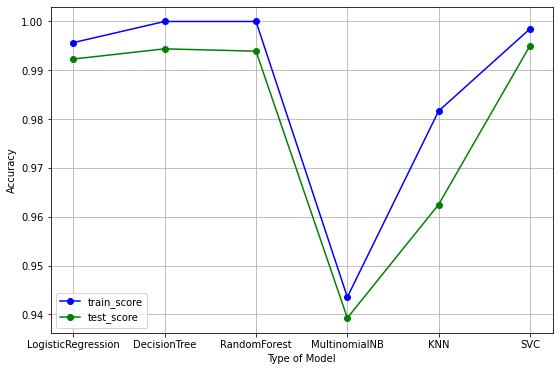

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.plot(dict_train.keys(),dict_train.values(),marker='o',c='b',label='train_score')
plt.plot(dict_test.keys(),dict_test.values(),marker='o',c='g',label='test_score')
plt.grid()
plt.legend()
plt.xlabel('Type of Model')
plt.ylabel('Accuracy')
print('test accuracy',dict_test)
print('train accuracy',dict_train)

**CROSS VALIDATION TO GET THE BEST ALGORITHM**

In [ ]:
from sklearn import model_selection
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('MultinomialNB', MultinomialNB( )))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3)))
models.append(('SVC', SVC(kernel='linear')))
seed = 7

# evaluate each model in turn
dict_models={}
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, )
	cv_results = model_selection.cross_val_score(model, X_stemm_bow_chi, Y, cv=kfold, scoring=scoring)
	dict_models[name]=cv_results.mean()
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LogisticRegression: 0.991538 (0.002257)
DecisionTreeClassifier: 0.993750 (0.001747)
RandomForestClassifier: 0.994423 (0.001949)
MultinomialNB: 0.955529 (0.013441)
KNN: 0.965385 (0.004510)
SVC: 0.995000 (0.002247)


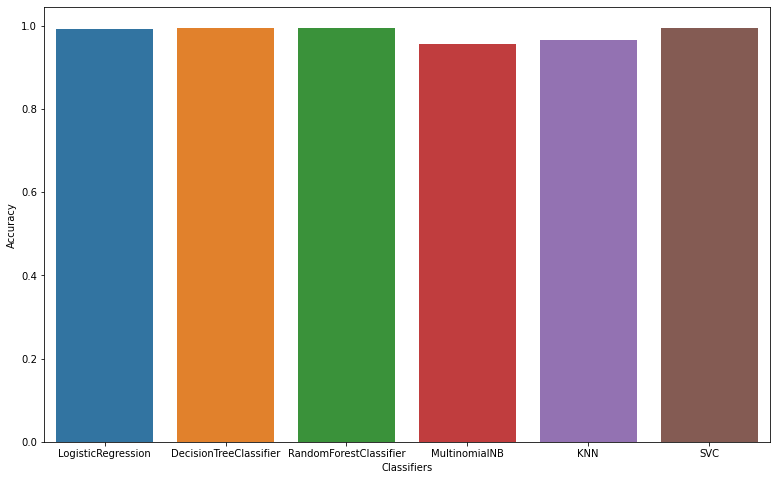

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(13, 8))
sns.barplot(x=list(dict_models.keys()),y=list(dict_models.values()),ax=ax)

plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.show()

**Hypothesis Testing between Random Forest Classifier and SVC**

In [ ]:
# use 5x2 statistical hypothesis testing procedure to compare two machine learning algorithms


from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
# evaluate model 1
model1 = RandomForestClassifier()


# evaluate model 2
model2 = SVC()

# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=X_stemm_bow, y=Y, scoring='accuracy', random_seed=1)
# summarize
print('P-value:',p, 't-Statistic:',t)
# interpret the result
if p <= 0.05:
	print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two models are significantly different.')
else:
	print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.')

P-value: 0.005637469150613033 t-Statistic: 4.639059295091509
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two models are significantly different.


# **TF-IDF VECTORIZER**

In [ ]:
tfidf1 = TfidfVectorizer()                                         # TF(t, d) = (Number of occurrences of word t in document(sentence)d) / (Total number of terms in document d)
                                                                    #IDF(t) = log((Total number of documents) / (Number of documents containing term t))
tfidf1.fit(df["lemm_content"].values)                              # IDF assign weight 0 forword that is common word in all sentence . or more common then less weight
X_stemm_tfidf = tfidf1.transform(df["lemm_content"].values)        # and TF- no of times persent word in sentence increse weight.
                                                                # unlike BOW ,it not put 0,1 that persent or not. it assine place of 0 and 1 ,put TF-IDF weights(value)

In [ ]:
X_stemm_tfidf

<20800x136880 sparse matrix of type '<class 'numpy.float64'>'
	with 5389595 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.model_selection import train_test_split
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X_stemm_tfidf, Y, test_size = 0.3)

**Logistic Regression**

In [ ]:
log_reg3=LogisticRegression()
log_reg3.fit(X_train3,Y_train3)

Y_lr_train_pred3 =log_reg3.predict(X_train3)
Y_lr_test_pred3 =log_reg3.predict(X_test3)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train3,Y_lr_train_pred3))

print(f"The accuracy score for train data is {accuracy_score(Y_train3,Y_lr_train_pred3)}")

print('The classification report is:')
print(classification_report(Y_train3,Y_lr_train_pred3))
dict_train={}
dict_train['LogisticRegression']=accuracy_score(Y_train3,Y_lr_train_pred3)

the confusion matrix for train data is:
[[7166  193]
 [ 162 7039]]
The accuracy score for train data is 0.9756181318681318
The classification report is:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      7359
           1       0.97      0.98      0.98      7201

    accuracy                           0.98     14560
   macro avg       0.98      0.98      0.98     14560
weighted avg       0.98      0.98      0.98     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test3,Y_lr_test_pred3))

print(f"the accuracy score for train data is {accuracy_score(Y_test3,Y_lr_test_pred3)}")

print('The classification report is:')
print(classification_report(Y_test3,Y_lr_test_pred3))
dict_test={}
dict_test['LogisticRegression']=accuracy_score(Y_test3,Y_lr_test_pred3)

the confusion matrix for test data is:
[[2849  179]
 [ 136 3076]]
the accuracy score for train data is 0.9495192307692307
The classification report is:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3028
           1       0.95      0.96      0.95      3212

    accuracy                           0.95      6240
   macro avg       0.95      0.95      0.95      6240
weighted avg       0.95      0.95      0.95      6240



**Decision Tree**

In [ ]:
my_dt3 = DecisionTreeClassifier()
my_dt3.fit(X_train3,Y_train3)

Y_dt_train_pred3 =my_dt3.predict(X_train3)
Y_dt_test_pred3 =my_dt3.predict(X_test3)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train3,Y_dt_train_pred3))

print(f"The accuracy score for train data is {accuracy_score(Y_train3,Y_dt_train_pred3)}")
dict_train['DecisionTree']=accuracy_score(Y_train3,Y_dt_train_pred3)
print('The classification report is:')
print(classification_report(Y_train3,Y_dt_train_pred3))

the confusion matrix for train data is:
[[7359    0]
 [   0 7201]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7359
           1       1.00      1.00      1.00      7201

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test3,Y_dt_test_pred3))

print(f"the accuracy score for test data is {accuracy_score(Y_test3,Y_dt_test_pred3)}")
dict_test['DecisionTree']=accuracy_score(Y_test3,Y_dt_test_pred3)
print('The classification report is:')
print(classification_report(Y_test3,Y_dt_test_pred3))

the confusion matrix for test data is:
[[2834  194]
 [ 201 3011]]
the accuracy score for test data is 0.936698717948718
The classification report is:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      3028
           1       0.94      0.94      0.94      3212

    accuracy                           0.94      6240
   macro avg       0.94      0.94      0.94      6240
weighted avg       0.94      0.94      0.94      6240



**Random Forest Classifier**

In [ ]:
my_rf3 = RandomForestClassifier()
my_rf3.fit(X_train3,Y_train3)

Y_rf_train_pred3 =my_rf3.predict(X_train3)
Y_rf_test_pred3 =my_rf3.predict(X_test3)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train3,Y_rf_train_pred3))

print(f"The accuracy score for train data is {accuracy_score(Y_train3,Y_rf_train_pred3)}")
dict_train['RandomForest']=accuracy_score(Y_train3,Y_rf_train_pred3)

print('The classification report is:')
print(classification_report(Y_train3,Y_rf_train_pred3))

the confusion matrix for train data is:
[[7359    0]
 [   0 7201]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7359
           1       1.00      1.00      1.00      7201

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test3,Y_rf_test_pred3))

print(f"the accuracy score for test data is {accuracy_score(Y_test3,Y_rf_test_pred3)}")
dict_test['RandomForest']=accuracy_score(Y_test3,Y_rf_test_pred3)

print('The classification report is:')
print(classification_report(Y_test3,Y_rf_test_pred3))

the confusion matrix for test data is:
[[2901  127]
 [ 314 2898]]
the accuracy score for test data is 0.9293269230769231
The classification report is:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      3028
           1       0.96      0.90      0.93      3212

    accuracy                           0.93      6240
   macro avg       0.93      0.93      0.93      6240
weighted avg       0.93      0.93      0.93      6240



**Multinomial Naive Bayes Classifier**

In [ ]:
my_nbc3= MultinomialNB()
my_nbc3= my_nbc3.fit(X_train3,Y_train3)

Y_nbc_train_pred3 = my_nbc3.predict(X_train3)
Y_nbc_test_pred3 = my_nbc3.predict(X_test3)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train3,Y_nbc_train_pred3))

print(f"The accuracy score for train data is {accuracy_score(Y_train3,Y_nbc_train_pred3)}")
dict_train['MultinomialNB']=accuracy_score(Y_train3,Y_nbc_train_pred3)

print('The classification report is:')
print(classification_report(Y_train3,Y_nbc_train_pred3))

the confusion matrix for train data is:
[[7307   52]
 [1476 5725]]
The accuracy score for train data is 0.8950549450549451
The classification report is:
              precision    recall  f1-score   support

           0       0.83      0.99      0.91      7359
           1       0.99      0.80      0.88      7201

    accuracy                           0.90     14560
   macro avg       0.91      0.89      0.89     14560
weighted avg       0.91      0.90      0.89     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test3,Y_nbc_test_pred3))

print(f"the accuracy score for test data is {accuracy_score(Y_test3,Y_nbc_test_pred3)}")
dict_test['MultinomialNB']=accuracy_score(Y_test3,Y_nbc_test_pred3)

print('The classification report is:')
print(classification_report(Y_test3,Y_nbc_test_pred3))

the confusion matrix for test data is:
[[3000   28]
 [ 902 2310]]
the accuracy score for test data is 0.8509615384615384
The classification report is:
              precision    recall  f1-score   support

           0       0.77      0.99      0.87      3028
           1       0.99      0.72      0.83      3212

    accuracy                           0.85      6240
   macro avg       0.88      0.85      0.85      6240
weighted avg       0.88      0.85      0.85      6240



**K-Nearest Neighbour**

In [ ]:
param_grid_knn3 = {"n_neighbors": [3,5,7,9,11,13,15]}

knn3 = KNeighborsClassifier()

grid_knn3= GridSearchCV(estimator=knn3,param_grid=param_grid_knn3,scoring="accuracy",verbose=1)

grid_knn3 = grid_knn3.fit(X_train3,Y_train3)

print(grid_knn3.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'n_neighbors': 3}


In [ ]:
my_knn3 = KNeighborsClassifier(n_neighbors=3)
my_knn3 = my_knn3.fit(X_train3,Y_train3)

Y_knn_train_pred3 = my_knn3.predict(X_train3)
Y_knn_test_pred3 = my_knn3.predict(X_test3)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train3,Y_knn_train_pred3))

print(f"the accuracy score for train data is {accuracy_score(Y_train3,Y_knn_train_pred3)}")
dict_train['KNN']=accuracy_score(Y_train3,Y_knn_train_pred3)
print('The classification report is:')
print(classification_report(Y_train3,Y_knn_train_pred3))

In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test3,Y_knn_test_pred3))

print(f"the accuracy score for test data is: {accuracy_score(Y_test3,Y_knn_test_pred3)}")
dict_test['KNN']=accuracy_score(Y_test3,Y_knn_test_pred3)
print('The classification report is:')
print(classification_report(Y_test3,Y_knn_test_pred3))

**SVC**

In [ ]:
param_grid_svm3= {"kernel": ['linear','rbf','poly','sigmoid']}

svm3 = SVC()

grid_svm3= GridSearchCV(estimator=svm3,param_grid=param_grid_svm3,scoring="accuracy",verbose=1)

grid_svm3 = grid_svm3.fit(X_train3,Y_train3)

print(grid_svm3.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'kernel': 'linear'}


In [ ]:
my_svm3 = SVC( kernel='linear')
my_svm3= my_svm3.fit(X_train3,Y_train3)

Y_svm_train_pred3 = my_svm3.predict(X_train3)
Y_svm_test_pred3 = my_svm3.predict(X_test3)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train3,Y_svm_train_pred3))

print(f"the accuracy score for train data is {accuracy_score(Y_train3,Y_svm_train_pred3)}")
#dict_train['SVC']=accuracy_score(Y_train3,Y_svm_train_pred3)
print('The classification report is:')
print(classification_report(Y_test3,Y_svm_test_pred3))

the confusion matrix for train data is:
[[7249   32]
 [  46 7233]]
the accuracy score for train data is 0.9946428571428572
The classification report is:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3106
           1       0.96      0.97      0.97      3134

    accuracy                           0.96      6240
   macro avg       0.96      0.96      0.96      6240
weighted avg       0.96      0.96      0.96      6240



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test3,Y_svm_test_pred3))

print(f"the accuracy score for test data is: {accuracy_score(Y_test3,Y_svm_test_pred3)}")
#dict_test['SVC']=accuracy_score(Y_test3,Y_svm_test_pred3)
print('The classification report is:')
print(classification_report(Y_test3,Y_svm_test_pred3))

the confusion matrix for test data is:
[[2990  116]
 [ 103 3031]]
the accuracy score for test data is: 0.9649038461538462
The classification report is:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3106
           1       0.96      0.97      0.97      3134

    accuracy                           0.96      6240
   macro avg       0.96      0.96      0.96      6240
weighted avg       0.96      0.96      0.96      6240



**Plotting acurracy of the models**

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.plot(dict_train.keys(),dict_train.values(),marker='o',c='b',label='train_score')
plt.plot(dict_test.keys(),dict_test.values(),marker='o',c='g',label='test_score')
plt.grid()
plt.legend()
plt.xlabel('Type of Model')
plt.ylabel('Accuracy')

**CROSS VALIDATION TO GET THE BEST ALGORITHM**

In [ ]:
from sklearn import model_selection
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('MultinomialNB', MultinomialNB( )))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3)))
models.append(('SVC', SVC(kernel='linear')))
seed = 7

# evaluate each model in turn
dict_models={}
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, )
	cv_results = model_selection.cross_val_score(model, X_stemm_tfidf, Y, cv=kfold, scoring=scoring)
	dict_models[name]=cv_results.mean()
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(13, 8))
sns.barplot(x=list(dict_models.keys()),y=list(dict_models.values()),ax=ax)

plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.show()

**Hypothesis Testing between Random forest classifier and Decision Tree Classifier**

In [ ]:
# use 5x2 statistical hypothesis testing procedure to compare two machine learning algorithms


from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
# evaluate model 1
model1 = RandomForestClassifier()


# evaluate model 2
model2 = DecisionTreeClassifier()

# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=X_stemm_bow, y=Y, scoring='accuracy', random_seed=1)
# summarize
print('P-value:',p, 't-Statistic:',t)
# interpret the result
if p <= 0.05:
	print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two models are significantly different.')
else:
	print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.')

P-value: 0.07280348856999914 t-Statistic: -2.2659891470568807
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.


# **TF-IDF VECTORIZER + CHI SQUARE TEST**

In [ ]:
X_names2 = tfidf1.get_feature_names()

C:\Users\adity\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
alpha =.05

In [ ]:
from sklearn.feature_selection import chi2
chi2, p = chi2(X_stemm_tfidf, Y)

In [ ]:
data2={'features':X_names2,'score':p}
df_features2=pd.DataFrame(data2)

In [ ]:
df_features_new2=df_features2[df_features2.score<alpha]
df_features_new2

features     score
5        aaron  0.005685
26      abedin  0.003941
28     abelson  0.016873
41       abort  0.005027
75      access  0.002144
...        ...       ...
17015      yve  0.000966
17058   zernik  0.021022
17089  zionist  0.021849
17102   zraick  0.000034
17112    zuess  0.002411

[1063 rows x 2 columns]

In [ ]:
X_names_new2=list(df_features_new2.features.values)


In [ ]:
vectorizer2 = TfidfVectorizer(vocabulary=X_names_new2)
vectorizer2.fit(df['stemm_content'].values)
X_stemm_tfidf_chi = vectorizer2.transform(df['stemm_content'].values)    #USEFUL

In [ ]:
X_stemm_tfidf_chi

<20800x1063 sparse matrix of type '<class 'numpy.float64'>'
	with 91622 stored elements in Compressed Sparse Row format>

In [ ]:
X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X_stemm_tfidf_chi, Y, test_size = 0.3)

**Logistic Regression**

In [ ]:
log_reg4=LogisticRegression()
log_reg4.fit(X_train4,Y_train4)

Y_lr_train_pred4 =log_reg4.predict(X_train4)
Y_lr_test_pred4 =log_reg4.predict(X_test4)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train4,Y_lr_train_pred4))

print(f"The accuracy score for train data is {accuracy_score(Y_train4,Y_lr_train_pred4)}")
dict_train={}
dict_train['LogisticRegression']=accuracy_score(Y_train4,Y_lr_train_pred4)
print('The classification report is:')
print(classification_report(Y_train4,Y_lr_train_pred4))

the confusion matrix for train data is:
[[7151  105]
 [  72 7232]]
The accuracy score for train data is 0.9878434065934066
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7256
           1       0.99      0.99      0.99      7304

    accuracy                           0.99     14560
   macro avg       0.99      0.99      0.99     14560
weighted avg       0.99      0.99      0.99     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test4,Y_lr_test_pred4))

print(f"the accuracy score for train data is {accuracy_score(Y_test4,Y_lr_test_pred4)}")
dict_test={}
dict_test['LogisticRegression']=accuracy_score(Y_test4,Y_lr_test_pred4)

print('The classification report is:')
print(classification_report(Y_test4,Y_lr_test_pred4))

the confusion matrix for test data is:
[[3072   59]
 [  47 3062]]
the accuracy score for train data is 0.9830128205128205
The classification report is:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3131
           1       0.98      0.98      0.98      3109

    accuracy                           0.98      6240
   macro avg       0.98      0.98      0.98      6240
weighted avg       0.98      0.98      0.98      6240



**Decision Tree**

In [ ]:
my_dt4 = DecisionTreeClassifier()
my_dt4.fit(X_train4,Y_train4)

Y_dt_train_pred4 =my_dt4.predict(X_train4)
Y_dt_test_pred4 =my_dt4.predict(X_test4)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train4,Y_dt_train_pred4))

print(f"The accuracy score for train data is {accuracy_score(Y_train4,Y_dt_train_pred4)}")
dict_train['DecisionTree']=accuracy_score(Y_train4,Y_dt_train_pred4)

print('The classification report is:')
print(classification_report(Y_train4,Y_dt_train_pred4))

the confusion matrix for train data is:
[[7249    7]
 [   5 7299]]
The accuracy score for train data is 0.9991758241758242
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7256
           1       1.00      1.00      1.00      7304

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test4,Y_dt_test_pred4))

print(f"the accuracy score for train data is {accuracy_score(Y_test4,Y_dt_test_pred4)}")
dict_test['DecisionTree']=accuracy_score(Y_test4,Y_dt_test_pred4)
print('The classification report is:')
print(classification_report(Y_test4,Y_dt_test_pred4))

the confusion matrix for test data is:
[[3101   30]
 [  46 3063]]
the accuracy score for train data is 0.9878205128205129
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3131
           1       0.99      0.99      0.99      3109

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Random Forest Classifier**

In [ ]:
my_rf4 = RandomForestClassifier()
my_rf4.fit(X_train4,Y_train4)

Y_rf_train_pred4 =my_rf4.predict(X_train4)
Y_rf_test_pred4 =my_rf4.predict(X_test4)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train4,Y_rf_train_pred4))

print(f"The accuracy score for train data is {accuracy_score(Y_train4,Y_rf_train_pred4)}")
dict_train['RandomForest']=accuracy_score(Y_train4,Y_rf_train_pred4)
print('The classification report is:')
print(classification_report(Y_train4,Y_rf_train_pred4))

the confusion matrix for train data is:
[[7248    8]
 [   4 7300]]
The accuracy score for train data is 0.9991758241758242
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7256
           1       1.00      1.00      1.00      7304

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test4,Y_rf_test_pred4))

print(f"the accuracy score for train data is {accuracy_score(Y_test4,Y_rf_test_pred4)}")
dict_test['RandomForest']=accuracy_score(Y_test4,Y_rf_test_pred4)
print('The classification report is:')
print(classification_report(Y_test4,Y_rf_test_pred4))

the confusion matrix for test data is:
[[3104   27]
 [  15 3094]]
the accuracy score for train data is 0.9932692307692308
The classification report is:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3131
           1       0.99      1.00      0.99      3109

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Multinomial Naive Bayes Classifier**

In [ ]:
my_nbc4= MultinomialNB()
my_nbc4= my_nbc4.fit(X_train4,Y_train4)

Y_nbc_train_pred4 = my_nbc4.predict(X_train4)
Y_nbc_test_pred4 = my_nbc4.predict(X_test4)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train4,Y_nbc_train_pred4))

print(f"The accuracy score for train data is {accuracy_score(Y_train4,Y_nbc_train_pred4)}")
dict_train['MultinomialNB']=accuracy_score(Y_train4,Y_nbc_train_pred4)
print('The classification report is:')
print(classification_report(Y_train4,Y_nbc_train_pred4))

the confusion matrix for train data is:
[[7211   45]
 [ 512 6792]]
The accuracy score for train data is 0.9617445054945055
The classification report is:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7256
           1       0.99      0.93      0.96      7304

    accuracy                           0.96     14560
   macro avg       0.96      0.96      0.96     14560
weighted avg       0.96      0.96      0.96     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test4,Y_nbc_test_pred4))

print(f"the accuracy score for train data is {accuracy_score(Y_test4,Y_nbc_test_pred4)}")
dict_test['MultinomialNB']=accuracy_score(Y_test4,Y_nbc_test_pred4)
print('The classification report is:')
print(classification_report(Y_test4,Y_nbc_test_pred4))

the confusion matrix for test data is:
[[3115   16]
 [ 296 2813]]
the accuracy score for train data is 0.95
The classification report is:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3131
           1       0.99      0.90      0.95      3109

    accuracy                           0.95      6240
   macro avg       0.95      0.95      0.95      6240
weighted avg       0.95      0.95      0.95      6240



**K-Nearest Neighbour**

In [ ]:
param_grid_knn4 = {"n_neighbors": [3,5,7,9,11,13,15]}

knn4 = KNeighborsClassifier()

grid_knn4= GridSearchCV(estimator=knn4,param_grid=param_grid_knn4,scoring="accuracy",verbose=1)

grid_knn4 = grid_knn4.fit(X_train4,Y_train4)

print(grid_knn4.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'n_neighbors': 3}


In [ ]:
my_knn4 = KNeighborsClassifier(n_neighbors=3)
my_knn4 = my_knn4.fit(X_train4,Y_train4)

Y_knn_train_pred4 = my_knn4.predict(X_train4)
Y_knn_test_pred4 = my_knn4.predict(X_test4)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train4,Y_knn_train_pred4))

print(f"the accuracy score for train data is {accuracy_score(Y_train4,Y_knn_train_pred4)}")
dict_train['KNN']=accuracy_score(Y_train4,Y_knn_train_pred4)
print('The classification report is:')
print(classification_report(Y_train4,Y_knn_train_pred4))

the confusion matrix for train data is:
[[7093  163]
 [  99 7205]]
the accuracy score for train data is 0.9820054945054945
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7256
           1       0.98      0.99      0.98      7304

    accuracy                           0.98     14560
   macro avg       0.98      0.98      0.98     14560
weighted avg       0.98      0.98      0.98     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test4,Y_knn_test_pred4))

print(f"the accuracy score for test data is: {accuracy_score(Y_test4,Y_knn_test_pred4)}")
dict_test['KNN']=accuracy_score(Y_test4,Y_knn_test_pred4)
print('The classification report is:')
print(classification_report(Y_test4,Y_knn_test_pred4))

the confusion matrix for test data is:
[[2999  132]
 [  95 3014]]
the accuracy score for test data is: 0.9636217948717949
The classification report is:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3131
           1       0.96      0.97      0.96      3109

    accuracy                           0.96      6240
   macro avg       0.96      0.96      0.96      6240
weighted avg       0.96      0.96      0.96      6240



**SVC**

In [ ]:
param_grid_svm4= {"kernel": ['linear','rbf','poly','sigmoid']}

svm4 = SVC()

grid_svm4= GridSearchCV(estimator=svm4,param_grid=param_grid_svm4,scoring="accuracy",verbose=1)

grid_svm4 = grid_svm4.fit(X_train4,Y_train4)

print(grid_svm4.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'kernel': 'rbf'}


In [ ]:
my_svm4 = SVC( kernel='rbf')
my_svm4= my_svm4.fit(X_train4,Y_train4)

Y_svm_train_pred4 = my_svm4.predict(X_train4)
Y_svm_test_pred4 = my_svm4.predict(X_test4)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train4,Y_svm_train_pred4))

print(f"the accuracy score for train data is {accuracy_score(Y_train4,Y_svm_train_pred4)}")
dict_train['SVC']=accuracy_score(Y_train4,Y_svm_train_pred4)
print('The classification report is:')
print(classification_report(Y_test4,Y_svm_test_pred4))

the confusion matrix for train data is:
[[7229   27]
 [  16 7288]]
the accuracy score for train data is 0.9970467032967033
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3131
           1       0.99      0.99      0.99      3109

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test4,Y_svm_test_pred4))

print(f"the accuracy score for test data is: {accuracy_score(Y_test4,Y_svm_test_pred4)}")
dict_test['SVC']=accuracy_score(Y_test4,Y_svm_test_pred4)
print('The classification report is:')
print(classification_report(Y_test4,Y_svm_test_pred4))

the confusion matrix for test data is:
[[3102   29]
 [  17 3092]]
the accuracy score for test data is: 0.9926282051282052
The classification report is:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3131
           1       0.99      0.99      0.99      3109

    accuracy                           0.99      6240
   macro avg       0.99      0.99      0.99      6240
weighted avg       0.99      0.99      0.99      6240



**Plotting accuracy of models**

Text(0, 0.5, 'Accuracy')

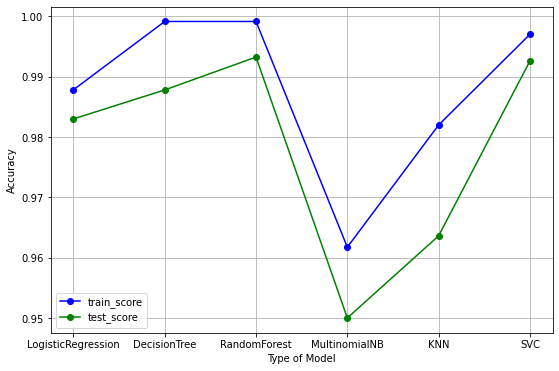

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.plot(dict_train.keys(),dict_train.values(),marker='o',c='b',label='train_score')
plt.plot(dict_test.keys(),dict_test.values(),marker='o',c='g',label='test_score')
plt.grid()
plt.legend()
plt.xlabel('Type of Model')
plt.ylabel('Accuracy')

**CROSS VALIDATION TO GET THE BEST ALGORITHM**

In [ ]:
from sklearn import model_selection
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('MultinomialNB', MultinomialNB( )))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3)))
models.append(('SVC', SVC(kernel='rbf')))
seed = 7

# evaluate each model in turn
dict_models={}
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, )
	cv_results = model_selection.cross_val_score(model, X_stemm_tfidf_chi, Y, cv=kfold, scoring=scoring)
	dict_models[name]=cv_results.mean()
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LogisticRegression: 0.985913 (0.002720)
DecisionTreeClassifier: 0.991202 (0.001361)
RandomForestClassifier: 0.993462 (0.001901)
MultinomialNB: 0.934375 (0.027794)
KNN: 0.968798 (0.002723)
SVC: 0.992885 (0.002392)


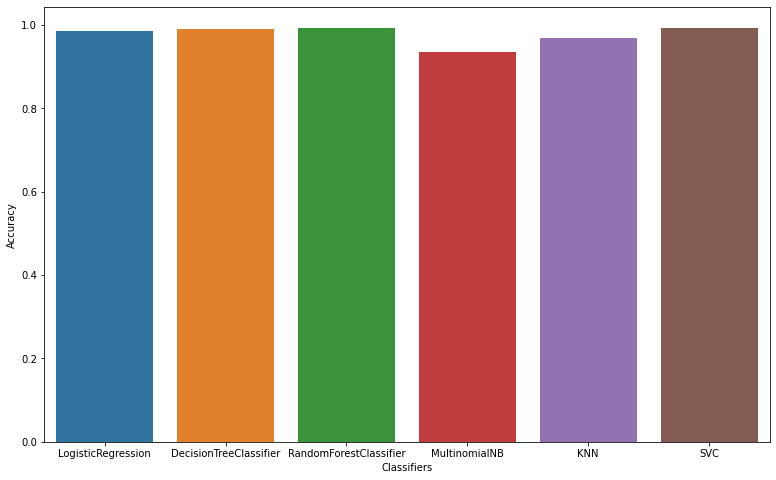

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(13, 8))
sns.barplot(x=list(dict_models.keys()),y=list(dict_models.values()),ax=ax)

plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.show()

**Hypothesis Testing between Random Forest Classifier and SVC**

In [ ]:
# use 5x2 statistical hypothesis testing procedure to compare two machine learning algorithms


from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
# evaluate model 1
model1 = RandomForestClassifier()


# evaluate model 2
model2 =  SVC(kernel='rbf')

# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=X_stemm_bow, y=Y, scoring='accuracy', random_seed=1)
# summarize
print('P-value:',p, 't-Statistic:',t)
# interpret the result
if p <= 0.05:
	print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two models are significantly different.')
else:
	print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.')

P-value: 0.002863651602026945 t-Statistic: 5.433548236224551
Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two models are significantly different.


# **WORD2VEC**

In [ ]:
import gensim

In [ ]:
def lemmetize(content):
    document = re.sub('[^a-zA-Z]',' ',str(content))
    document = document.lower()
    document = document.split()
    document = [WordNetLemmatizer().lemmatize(word) for word in document if not word in stopwords.words('english')]
    return document

In [ ]:
df['list_lemm_content']=(df['title']+' '+df['text']).apply(lemmetize)
df.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1   
1  Ever get the feeling your life circles the rou...      0   
2  Why the Truth Might Get You Fired October 29, ...      1   
3  Videos 15 Civilians Killed In Single US Airstr...      1   
4  Print \nAn Iranian woman has been sentenced to...      1   

                                        lemm_content  \
0  house dem aide even see comey letter jason cha...   
1  flynn hillary clinton big woman campus breitba...   
2  truth might get fired truth might get fired oc...   
3  civilian killed single u airstrike identified ...   
4  iranian woman jailed fictional unpublished sto...   

                                   list_lemm_content  
0  [house, dem, aide, even, see, comey, letter, j...  
1  [flynn, hillary, clinton, big, woman, campus, ...  
2  [truth, might, get, fired, truth, might, get, ...  
3  [civilian, killed, single, u, airstrike, ident...  
4  [iranian, woman, jailed, fictional, unpublishe...

In [ ]:
w2v_model = gensim.models.Word2Vec(df['list_lemm_content'],vector_size=100,window=50,min_count=1)

                                  # its a Embedding model that embed each word that come one hot vector of word * weight matrics give embeding vector of that word





In [ ]:
words = set(w2v_model.wv.index_to_key )                        #This line extracts the vocabulary (set of words) that the Word2Vec model has learned.
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words]) for ls in df['list_lemm_content']],dtype=object)


                                                        # For each list of tokens in 'list_lemm_content',
                                                         #it checks if each token exists in the learned vocabulary (words). If the token is in the vocabulary,
                                                        #it retrieves its corresponding vector from the Word2Vec model and collects these vectors into an array (X_train_vect).
                                                        #Each element in X_train_vect is an array of word vectors corresponding to the words in the tokenized text.

In [ ]:
X_train_vect_avg = []                                               # it did avg of embedding vector in each sentence and make one vector for each sentence.
for v in X_train_vect:
    if v.size:                                                  # # # in sentiment analisis ,a sentence= embeding matrix ,aply FNN layer to conver into one vector.
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))

In [ ]:
X_train_vect_avg

[array([-0.23392767,  0.30378604, -1.3920318 , -0.3447012 ,  0.76602316,
        -0.78097683, -0.34133577, -0.7470661 , -0.08536197,  0.8635494 ,
        -0.7960574 ,  1.0166297 , -0.2966243 , -0.05600476,  0.4021695 ,
         0.7334996 ,  0.18962304, -0.82507414,  0.57912177,  0.6207847 ,
        -0.29755187,  1.2612222 ,  1.4371991 ,  1.2500154 ,  0.7049794 ,
         0.8330207 ,  0.2144556 ,  0.5940558 ,  0.64524287,  0.03433391,
        -0.16683155, -0.46495003, -0.15694417,  0.4415325 , -0.56336284,
         1.5139942 ,  0.6126486 , -0.03223367, -0.41181543,  1.3814975 ,
         0.9226198 , -0.22301191,  0.42583868, -0.50439286,  1.0417325 ,
        -0.4289692 ,  0.5689585 , -0.79607624, -0.7699945 , -0.05241017,
        -0.20023596, -0.3446161 ,  0.545958  ,  0.24932843, -0.17006731,
         0.6218444 ,  0.12639476, -0.07296856, -0.02854179,  0.12479705,
        -0.30134392,  0.97616684,  0.18199708, -0.6306828 ,  0.47663185,
        -0.25465074,  1.0772301 , -1.5379062 ,  0.3

In [ ]:
X_lemm_w2v = X_train_vect_avg
#USEFUL

In [ ]:
X_lemm_w2v

[array([-0.23392767,  0.30378604, -1.3920318 , -0.3447012 ,  0.76602316,
        -0.78097683, -0.34133577, -0.7470661 , -0.08536197,  0.8635494 ,
        -0.7960574 ,  1.0166297 , -0.2966243 , -0.05600476,  0.4021695 ,
         0.7334996 ,  0.18962304, -0.82507414,  0.57912177,  0.6207847 ,
        -0.29755187,  1.2612222 ,  1.4371991 ,  1.2500154 ,  0.7049794 ,
         0.8330207 ,  0.2144556 ,  0.5940558 ,  0.64524287,  0.03433391,
        -0.16683155, -0.46495003, -0.15694417,  0.4415325 , -0.56336284,
         1.5139942 ,  0.6126486 , -0.03223367, -0.41181543,  1.3814975 ,
         0.9226198 , -0.22301191,  0.42583868, -0.50439286,  1.0417325 ,
        -0.4289692 ,  0.5689585 , -0.79607624, -0.7699945 , -0.05241017,
        -0.20023596, -0.3446161 ,  0.545958  ,  0.24932843, -0.17006731,
         0.6218444 ,  0.12639476, -0.07296856, -0.02854179,  0.12479705,
        -0.30134392,  0.97616684,  0.18199708, -0.6306828 ,  0.47663185,
        -0.25465074,  1.0772301 , -1.5379062 ,  0.3

In [ ]:
X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X_lemm_w2v, Y, test_size = 0.3)

**Logistic Regression**

In [ ]:
log_reg5=LogisticRegression()
log_reg5.fit(X_train5,Y_train5)

Y_lr_train_pred5 =log_reg5.predict(X_train5)
Y_lr_test_pred5 =log_reg5.predict(X_test5)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train5,Y_lr_train_pred5))

print(f"The accuracy score for train data is {accuracy_score(Y_train5,Y_lr_train_pred5)}")
dict_train={}
dict_train['LogisticRegression']=accuracy_score(Y_train5,Y_lr_train_pred5)
print('The classification report is:')
print(classification_report(Y_train5,Y_lr_train_pred5))

the confusion matrix for train data is:
[[6745  522]
 [ 574 6719]]
The accuracy score for train data is 0.9247252747252748
The classification report is:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      7267
           1       0.93      0.92      0.92      7293

    accuracy                           0.92     14560
   macro avg       0.92      0.92      0.92     14560
weighted avg       0.92      0.92      0.92     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test5,Y_lr_test_pred5))

print(f"the accuracy score for train data is {accuracy_score(Y_test5,Y_lr_test_pred5)}")

print('The classification report is:')
print(classification_report(Y_test5,Y_lr_test_pred5))
dict_test={}
dict_test['LogisticRegression']=accuracy_score(Y_test5,Y_lr_test_pred5)

the confusion matrix for test data is:
[[2886  234]
 [ 248 2872]]
the accuracy score for train data is 0.9227564102564103
The classification report is:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      3120
           1       0.92      0.92      0.92      3120

    accuracy                           0.92      6240
   macro avg       0.92      0.92      0.92      6240
weighted avg       0.92      0.92      0.92      6240



**Decision Tree**

In [ ]:
my_dt5 = DecisionTreeClassifier()
my_dt5.fit(X_train5,Y_train5)

Y_dt_train_pred5 =my_dt5.predict(X_train5)
Y_dt_test_pred5 =my_dt5.predict(X_test5)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train5,Y_dt_train_pred5))

print(f"The accuracy score for train data is {accuracy_score(Y_train5,Y_dt_train_pred5)}")
dict_train['DecisionTree']=accuracy_score(Y_train5,Y_dt_train_pred5)
print('The classification report is:')
print(classification_report(Y_train5,Y_dt_train_pred5))

the confusion matrix for train data is:
[[7267    0]
 [   0 7293]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7267
           1       1.00      1.00      1.00      7293

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test5,Y_dt_test_pred5))

print(f"the accuracy score for train data is {accuracy_score(Y_test5,Y_dt_test_pred5)}")
dict_test['DecisionTree']=accuracy_score(Y_test5,Y_dt_test_pred5)
print('The classification report is:')
print(classification_report(Y_test5,Y_dt_test_pred5))

the confusion matrix for test data is:
[[2536  584]
 [ 573 2547]]
the accuracy score for train data is 0.8145833333333333
The classification report is:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      3120
           1       0.81      0.82      0.81      3120

    accuracy                           0.81      6240
   macro avg       0.81      0.81      0.81      6240
weighted avg       0.81      0.81      0.81      6240



**Random Forest Classifier**

In [ ]:
my_rf5 = RandomForestClassifier()
my_rf5.fit(X_train5,Y_train5)

Y_rf_train_pred5=my_rf5.predict(X_train5)
Y_rf_test_pred5 =my_rf5.predict(X_test5)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train5,Y_rf_train_pred5))

print(f"The accuracy score for train data is {accuracy_score(Y_train5,Y_rf_train_pred5)}")
dict_train['RandomForest']=accuracy_score(Y_train5,Y_rf_train_pred5)
print('The classification report is:')
print(classification_report(Y_train5,Y_rf_train_pred5))

the confusion matrix for train data is:
[[7267    0]
 [   0 7293]]
The accuracy score for train data is 1.0
The classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7267
           1       1.00      1.00      1.00      7293

    accuracy                           1.00     14560
   macro avg       1.00      1.00      1.00     14560
weighted avg       1.00      1.00      1.00     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test5,Y_rf_test_pred5))

print(f"the accuracy score for train data is {accuracy_score(Y_test5,Y_rf_test_pred5)}")
dict_test['RandomForest']=accuracy_score(Y_test5,Y_rf_test_pred5)
print('The classification report is:')
print(classification_report(Y_test5,Y_rf_test_pred5))

the confusion matrix for test data is:
[[2881  239]
 [ 276 2844]]
the accuracy score for train data is 0.9174679487179487
The classification report is:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      3120
           1       0.92      0.91      0.92      3120

    accuracy                           0.92      6240
   macro avg       0.92      0.92      0.92      6240
weighted avg       0.92      0.92      0.92      6240



**K-Nearest Neighbour**

In [ ]:
param_grid_knn5 = {"n_neighbors": [3,5,7,9,11,13,15]}

knn5 = KNeighborsClassifier()

grid_knn5= GridSearchCV(estimator=knn5,param_grid=param_grid_knn5,scoring="accuracy",verbose=1)

grid_knn5 = grid_knn5.fit(X_train5,Y_train5)

print(grid_knn5.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
{'n_neighbors': 5}


In [ ]:
my_knn5 = KNeighborsClassifier(n_neighbors=7)
my_knn5 = my_knn5.fit(X_train5,Y_train5)

Y_knn_train_pred5 = my_knn5.predict(X_train5)
Y_knn_test_pred5 = my_knn5.predict(X_test5)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train5,Y_knn_train_pred5))

print(f"the accuracy score for train data is {accuracy_score(Y_train5,Y_knn_train_pred5)}")
dict_train['KNN']=accuracy_score(Y_train5,Y_knn_train_pred5)
print('The classification report is:')
print(classification_report(Y_train5,Y_knn_train_pred5))

the confusion matrix for train data is:
[[6922  345]
 [ 810 6483]]
the accuracy score for train data is 0.9206730769230769
The classification report is:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      7267
           1       0.95      0.89      0.92      7293

    accuracy                           0.92     14560
   macro avg       0.92      0.92      0.92     14560
weighted avg       0.92      0.92      0.92     14560



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test5,Y_knn_test_pred5))

print(f"the accuracy score for test data is: {accuracy_score(Y_test5,Y_knn_test_pred5)}")
dict_test['KNN']=accuracy_score(Y_test5,Y_knn_test_pred5)
print('The classification report is:')
print(classification_report(Y_test5,Y_knn_test_pred5))

the confusion matrix for test data is:
[[2923  197]
 [ 417 2703]]
the accuracy score for test data is: 0.9016025641025641
The classification report is:
              precision    recall  f1-score   support

           0       0.88      0.94      0.90      3120
           1       0.93      0.87      0.90      3120

    accuracy                           0.90      6240
   macro avg       0.90      0.90      0.90      6240
weighted avg       0.90      0.90      0.90      6240



**SVC**

In [ ]:
param_grid_svm5= {"kernel": ['linear','rbf','poly','sigmoid']}

svm5 = SVC()

grid_svm5= GridSearchCV(estimator=svm5,param_grid=param_grid_svm5,scoring="accuracy",verbose=1)

grid_svm5 = grid_svm5.fit(X_train5,Y_train5)

print(grid_svm5.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'kernel': 'rbf'}


In [ ]:
my_svm5 = SVC( kernel='linear')
my_svm5= my_svm5.fit(X_train5,Y_train5)

Y_svm_train_pred5 = my_svm5.predict(X_train5)
Y_svm_test_pred5 = my_svm5.predict(X_test5)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train5,Y_svm_train_pred5))

print(f"the accuracy score for train data is {accuracy_score(Y_train5,Y_svm_train_pred5)}")
dict_train['SVC']=accuracy_score(Y_train5,Y_svm_train_pred5)
print('The classification report is:')
print(classification_report(Y_test5,Y_svm_test_pred5))

the confusion matrix for train data is:
[[6779  488]
 [ 580 6713]]
the accuracy score for train data is 0.9266483516483517
The classification report is:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      3120
           1       0.93      0.92      0.92      3120

    accuracy                           0.93      6240
   macro avg       0.93      0.93      0.93      6240
weighted avg       0.93      0.93      0.93      6240



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test5,Y_svm_test_pred5))

print(f"the accuracy score for test data is: {accuracy_score(Y_test5,Y_svm_test_pred5)}")
dict_test['SVC']=accuracy_score(Y_test5,Y_svm_test_pred5)

print('The classification report is:')
print(classification_report(Y_test5,Y_svm_test_pred5))

the confusion matrix for test data is:
[[2903  217]
 [ 250 2870]]
the accuracy score for test data is: 0.9251602564102565
The classification report is:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      3120
           1       0.93      0.92      0.92      3120

    accuracy                           0.93      6240
   macro avg       0.93      0.93      0.93      6240
weighted avg       0.93      0.93      0.93      6240



**Gaussian Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf= clf.fit(X_train5,Y_train5)

Y_nbc_train_pred5 = clf.predict(X_train5)
Y_nbc_test_pred5 = clf.predict(X_test5)

In [ ]:
print(f"the confusion matrix for train data is:")
print(confusion_matrix(Y_train5,Y_nbc_train_pred5))

print(f"the accuracy score for train data is {accuracy_score(Y_train5,Y_nbc_train_pred5)}")
dict_train['GaussianNB']=accuracy_score(Y_train5,Y_nbc_train_pred5)
print('The classification report is:')
print(classification_report(Y_test5,Y_nbc_test_pred5))

the confusion matrix for train data is:
[[6370  897]
 [2472 4821]]
the accuracy score for train data is 0.7686126373626374
The classification report is:
              precision    recall  f1-score   support

           0       0.72      0.88      0.79      3120
           1       0.84      0.66      0.74      3120

    accuracy                           0.77      6240
   macro avg       0.78      0.77      0.77      6240
weighted avg       0.78      0.77      0.77      6240



In [ ]:
print(f"the confusion matrix for test data is:")
print(confusion_matrix(Y_test5,Y_nbc_test_pred5))

print(f"the accuracy score for test data is: {accuracy_score(Y_test5,Y_nbc_test_pred5)}")
dict_test['GaussianNB']=accuracy_score(Y_test5,Y_nbc_test_pred5)
print('The classification report is:')
print(classification_report(Y_test5,Y_nbc_test_pred5))

the confusion matrix for test data is:
[[2742  378]
 [1070 2050]]
the accuracy score for test data is: 0.767948717948718
The classification report is:
              precision    recall  f1-score   support

           0       0.72      0.88      0.79      3120
           1       0.84      0.66      0.74      3120

    accuracy                           0.77      6240
   macro avg       0.78      0.77      0.77      6240
weighted avg       0.78      0.77      0.77      6240



**Plotting accuracy of models**

Text(0, 0.5, 'Accuracy')

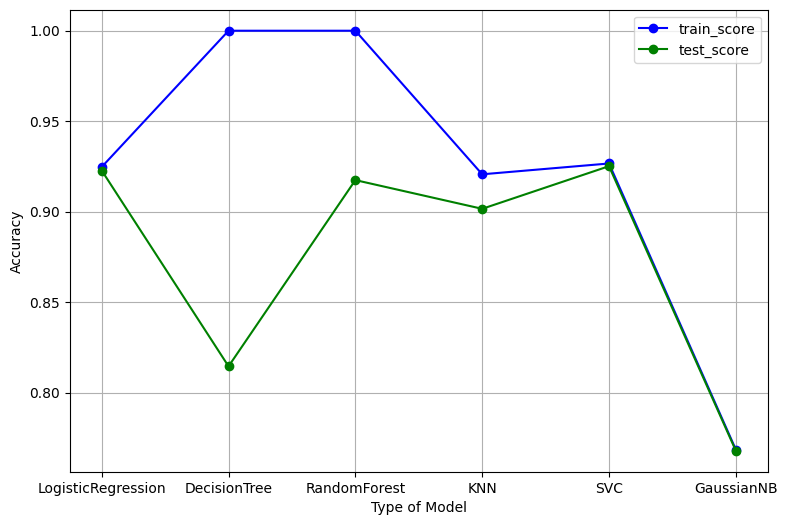

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.plot(dict_train.keys(),dict_train.values(),marker='o',c='b',label='train_score')
plt.plot(dict_test.keys(),dict_test.values(),marker='o',c='g',label='test_score')
plt.grid()
plt.legend()
plt.xlabel('Type of Model')
plt.ylabel('Accuracy')

**CROSS VALIDATION TO GET THE BEST ALGORITHM**

In [ ]:
from sklearn import model_selection
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('GaussianNB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=7)))
models.append(('SVC', SVC(kernel='linear')))
seed = 7

# evaluate each model in turn
dict_models={}
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, )
	cv_results = model_selection.cross_val_score(model, X_lemm_w2v, Y, cv=kfold, scoring=scoring)
	dict_models[name]=cv_results.mean()
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression: 0.923798 (0.007529)
DecisionTreeClassifier: 0.824615 (0.008290)
RandomForestClassifier: 0.917981 (0.005963)
GaussianNB: 0.772356 (0.010673)
KNN: 0.901971 (0.007434)
SVC: 0.924519 (0.006468)


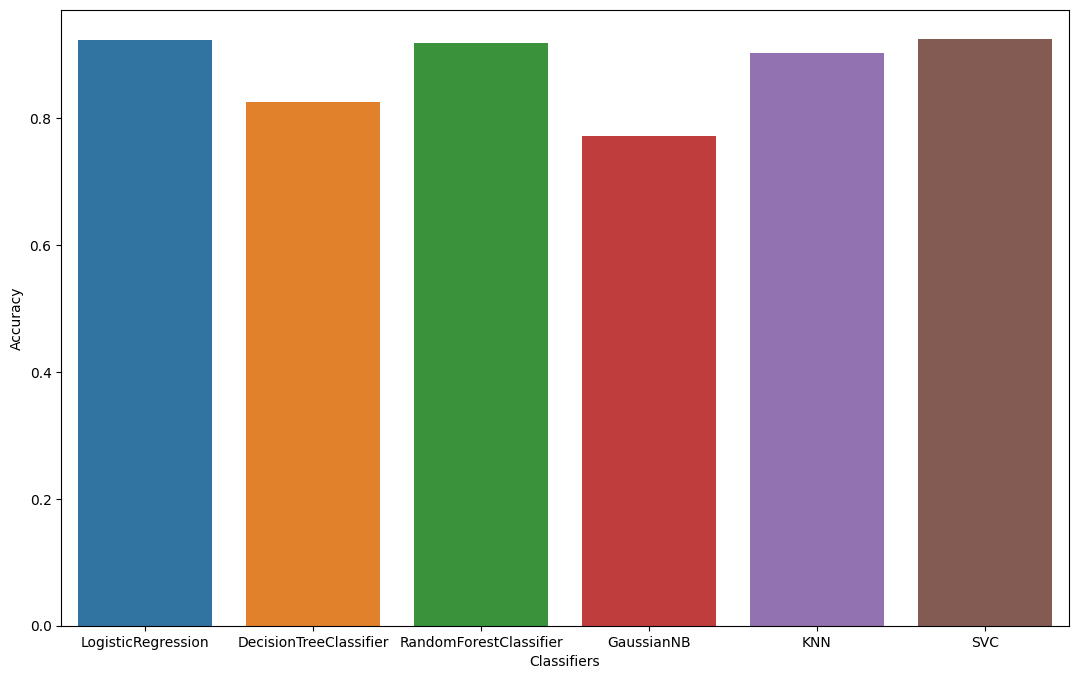

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(13, 8))
sns.barplot(x=list(dict_models.keys()),y=list(dict_models.values()),ax=ax)

plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.show()

**Hypothesis Testing between Random Forest Classifier and SVC**

In [ ]:
# use 5x2 statistical hypothesis testing procedure to compare two machine learning algorithms


from mlxtend.evaluate import paired_ttest_5x2cv
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
# evaluate model 1
model1 = RandomForestClassifier()


# evaluate model 2
model2 =  SVC(kernel='linear')

# check if difference between algorithms is real
t, p = paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=X_stemm_bow, y=Y, scoring='accuracy', random_seed=1)
# summarize
print('P-value:',p, 't-Statistic:',t)
# interpret the result
if p <= 0.05:
	print('Since p<0.05, We can reject the null-hypothesis that both models perform equally well on this dataset. We may conclude that the two models are significantly different.')
else:
	print('Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.')

P-value: 0.1710219814771148 t-Statistic: -1.597605386535302
Since p>0.05, we cannot reject the null hypothesis and may conclude that the performance of the two models are probably same.


#BOW----LogisticRegression(96.2)
#TF-IDF----SVM(96.5)
#WORD2VEC----SVM(92.5)